### Imports

### Load Data 

In [10]:
import pandas as pd
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest,\
VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

import hackday
import fine_tuning
alvo = 'limite_adicional'
cols_selected  = ['taxa_juros',
 'dias_atraso_dt_venc',
 'num_pgtos_atrasados',
 'num_cartoes_credito',
 'divida/saldos_atuais',
 'num_contas_bancarias',
 'idade',
 'divida_atual/renda_mensal',
 'num_consultas_credito',
 'taxa_utilizacao_credito',
 'score_credito',
 'renda_anual',
 'num_emprestimos']

# load data
df_raw, df_test = hackday.load_data()

# outlier treatment
df = hackday.outlier_treatment(df_raw)

df = hackday.feature_engineering(df)

df = hackday.data_preparation_train(df)

X = df[cols_selected]
# .drop(['id_cliente', 'limite_adicional'], axis=1)
y = df['limite_adicional']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [13]:
# X_train, y_train = hackday.balance_features(X_train, y_train)

In [2]:
n_estimators = np.arange(100, 200, 20)
learning_rate = np.arange(0.010, 0.025, 0.001)
num_leaves = [28, 29, 30, 31]


#### FINE TUNNING - LGBM

In [11]:
import random
results = pd.DataFrame()
count = 0
for i in range(300):
    
    learning_rate = random.choice(np.arange(0.15, 0.2, 0.005))
    num_leaves = random.choice(np.arange(70,90,5))
    max_depth = random.choice(np.arange(50,150,20))
    min_child_weight = random.choice(np.arange(0.001,0.003,0.0005))
    n_estimators = random.choice(np.arange(50,300,50))
    boosting_type = 'gbdt'
#     n_estimators = random.choice(np.arange(100,200,10))


    model = LGBMClassifier(learning_rate = learning_rate,
                          num_leaves = num_leaves,
                          max_depth =max_depth ,
                         n_estimators = n_estimators,
                          min_child_weight=min_child_weight,
                          boosting_type= boosting_type)
    
    model.fit(X_train, y_train)
    threshold = hackday.optimal_threshold(model, X_test, y_test)
    f1 =  hackday.cross_validation('lgbm', model, X_train, y_train, threshold=threshold, ensemble=False)
    
    results.loc[count, 'f1'] = f1
    results.loc[count, 'threshold'] = threshold
    results.loc[count, 'learning_rate'] = learning_rate
    results.loc[count, 'num_leaves'] = num_leaves
    results.loc[count, 'n_estimators'] = n_estimators
    results.loc[count, 'min_child_weight'] = min_child_weight
    results.loc[count, 'max_depth'] = max_depth
    count+=1
    print(count)

Best threshold: 0.6400000000000001
F1 : 0.8681578947368422 +/- 0.007633847212821187
Precision : 0.6396047018555409 +/- 0.040653688399787634
Recall : 0.41096269311205563 +/- 0.03359764258959601

1
Best threshold: 0.56
F1 : 0.8671052631578947 +/- 0.007361368805631239
Precision : 0.6160481274241993 +/- 0.04152455575559701
Recall : 0.4643020980908048 +/- 0.015246018793401627

2
Best threshold: 0.51
F1 : 0.868421052631579 +/- 0.00584008974241373
Precision : 0.6150998342604792 +/- 0.02699908288817702
Recall : 0.48317816906159344 +/- 0.029625437873288817

3
Best threshold: 0.6500000000000001
F1 : 0.869342105263158 +/- 0.006507506852041189
Precision : 0.6447994951164 +/- 0.04318854142517001
Recall : 0.4191830263779262 +/- 0.01935732239610865

4
Best threshold: 0.51
F1 : 0.8661842105263158 +/- 0.008441586806497597
Precision : 0.606459750306272 +/- 0.03845884136226937
Recall : 0.4790663158604871 +/- 0.011955031925806473

5
Best threshold: 0.6700000000000002
F1 : 0.871842105263158 +/- 0.006829441

Best threshold: 0.5
F1 : 0.8672368421052632 +/- 0.0067014903043404375
Precision : 0.6106046956622063 +/- 0.03327865523739917
Recall : 0.48153207852661406 +/- 0.01349175687502433

45
Best threshold: 0.7200000000000002
F1 : 0.8690789473684213 +/- 0.003168840678629566
Precision : 0.6660047764338382 +/- 0.024387870910718198
Recall : 0.3707886392767996 +/- 0.025367935088358693

46
Best threshold: 0.5
F1 : 0.868421052631579 +/- 0.00832178331623254
Precision : 0.6119666463693042 +/- 0.035429160236033944
Recall : 0.4954867435741752 +/- 0.021390535003933654

47


KeyboardInterrupt: 

In [ ]:
fine_tuning.tuning_rf(X_train, X_test, y_train, y_test, K=10)
fine_tuning.tuning_ada(X_train, X_test, y_train, y_test, K=10)
fine_tuning.tuning_lgbm(X_train, X_test, y_train, y_test, K=10)

In [54]:
best = results.sort_values('f1', ascending=False).convert_dtypes()

threshold = best.head(1)['threshold'].values[0]
params = dict(best.iloc[0,2:])

params
params['boosting_type'] = 'gbdt'

In [4]:
lgbm = LGBMClassifier(learning_rate    =    0.15,
num_leaves      =     85,
n_estimators   =     150,
min_child_weight =   0.002,
max_depth       =    130)

In [6]:
hackday.cross_validation('lgbm',
    lgbm,
    X_train,
    y_train,
    threshold=0.5,
    ensemble=False,
    n_splits=5,)

F1 : 0.8711578947368421 +/- 0.00968421052631578
Precision : 0.6203878594354401 +/- 0.043382886109450236
Recall : 0.46784787472035794 +/- 0.022579959945370463



0.8711578947368421

In [65]:
lgbm.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.15, max_depth=130, min_child_weight=0.002,
               n_estimators=150, num_leaves=85)

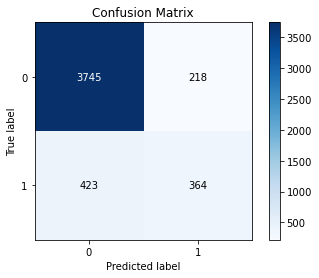

In [66]:
hackday.plot_cm(lgbm, X_test, y_test)

In [ ]:
# (learning_rate=0.165, num_leaves = 70.0, n_estimators = 50.0, min_child_weight = 0.0025)
0.874316


In [ ]:
FINE TUNING - RANDOM FOREST

In [24]:
import random
results_rf = pd.DataFrame()
count = 0

for i in range(300):
    
    max_depth = random.choice(np.arange(70,100,20))
    min_samples_split = random.choice([2,3,4,5])
    min_child_weight = random.choice(np.arange(0.001,0.003,0.0005))
    min_samples_leaf = random.choice([1,2,3])
    n_estimators = random.choice(np.arange(200,300,50))
#     n_estimators = random.choice(np.arange(100,200,10))


    model = RandomForestClassifier(n_estimators = n_estimators,
                          max_depth =max_depth ,
                          min_samples_leaf=min_samples_leaf,
                          min_samples_split=min_samples_split)
    
    model.fit(X_train, y_train)
    threshold = hackday.optimal_threshold(model, X_test, y_test)
    f1 =  hackday.cross_validation('rf', model, X_train, y_train, threshold=threshold, ensemble=False)
    
    results_rf.loc[count, 'f1'] = f1
    results_rf.loc[count, 'threshold'] = threshold
    results_rf.loc[count, 'n_estimators'] = n_estimators
    results_rf.loc[count, 'max_depth'] = max_depth
    results_rf.loc[count, 'min_samples_leaf'] = min_samples_leaf
    results_rf.loc[count, 'min_samples_split'] = min_samples_split
    
    count+=1
    print(count)

Best threshold: 0.5
F1 : 0.8772631578947369 +/- 0.008088156931494107
Precision : 0.6666026509313749 +/- 0.04351941819599918
Recall : 0.4410290827740492 +/- 0.026785764702862876

1
Best threshold: 0.5
F1 : 0.8734736842105264 +/- 0.008378841575634689
Precision : 0.6517132171410482 +/- 0.04652810256541631
Recall : 0.4236420581655481 +/- 0.04317694798894365

2
Best threshold: 0.5
F1 : 0.8766315789473685 +/- 0.008510055971119028
Precision : 0.671573810211666 +/- 0.040289883543216796
Recall : 0.4196420581655481 +/- 0.034337355701432835

3
Best threshold: 0.5
F1 : 0.8753684210526316 +/- 0.006475181683886137
Precision : 0.6634233553970394 +/- 0.03258108135435894
Recall : 0.4209574944071588 +/- 0.03430464009368148

4
Best threshold: 0.5
F1 : 0.8783157894736842 +/- 0.0117329471941834
Precision : 0.6742979699428298 +/- 0.060265160468645974
Recall : 0.43975838926174504 +/- 0.034983316594916804

5
Best threshold: 0.5
F1 : 0.8751578947368422 +/- 0.009775315171573842
Precision : 0.657043910948425 +/-

KeyboardInterrupt: 

In [15]:
results_rf.sort_values('f1', ascending=False).head(5)

,f1,threshold,max_depth,num_leaves,n_estimators,min_child_weight
1,0.880211,0.5,70.0,70.0,250.0,0.0010
4,0.878737,0.5,90.0,70.0,250.0,0.0015
3,0.877474,0.5,70.0,70.0,250.0,0.0025
0,0.876632,0.5,90.0,70.0,200.0,0.0020
10,0.876211,0.5,90.0,70.0,250.0,0.0025


In [8]:
import random
results_ada = pd.DataFrame()
count = 0

for i in range(10):
    
    learning_rate = random.choice(np.arange(1.0,1.5,0.005))
    n_estimators = random.choice(np.arange(50,300,50))
    algorithm = random.choice(['SAMME', 'SAMME.R'])
#     n_estimators = random.choice(np.arange(100,200,10))

    model = AdaBoostClassifier(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    algorithm=algorithm,
    random_state=42,)
    
    model.fit(X_train, y_train)
    threshold = hackday.optimal_threshold(model, X_test, y_test)
    f1 =  hackday.cross_validation('ada', model, X_train, y_train, threshold=threshold, ensemble=False)
    
    results_ada.loc[count, 'f1'] = f1
    results_ada.loc[count, 'threshold'] = threshold
    results_ada.loc[count, 'n_estimators'] = n_estimators
    results_ada.loc[count, 'learning_rate'] = learning_rate
    results_ada.loc[count, 'algorithm'] = algorithm
    
    count+=1
    print(count)
return results_ada.sort_values('f1', ascending=False)

Best threshold: 0.5
F1 : 0.8717894736842104 +/- 0.006603952480571831
Precision : 0.6433387508751381 +/- 0.03432057116839266
Recall : 0.4533625730994152 +/- 0.027133179540222915

1
Best threshold: 0.5
F1 : 0.8701052631578948 +/- 0.005008579896155941
Precision : 0.6318730487522959 +/- 0.02771062086490139
Recall : 0.45862573099415205 +/- 0.018269589885161773

2
Best threshold: 0.5
F1 : 0.8688421052631579 +/- 0.0076661648235929
Precision : 0.6290829559110191 +/- 0.036852678696208244
Recall : 0.4467922256621947 +/- 0.03870179828376315

3
Best threshold: 0.5
F1 : 0.8646315789473684 +/- 0.005750105382630628
Precision : 0.6012872805463905 +/- 0.02125898416440056
Recall : 0.4611971104231166 +/- 0.046917291762236885

4
Best threshold: 0.5
F1 : 0.8707368421052631 +/- 0.00721340703116285
Precision : 0.6396916742277567 +/- 0.0369654021725883
Recall : 0.44680082559339523 +/- 0.019488427033372415

5
Best threshold: 0.5
F1 : 0.8682105263157893 +/- 0.005465581046630432
Precision : 0.6216919130906963 +/

In [9]:
results_ada.sort_values('f1', ascending=False)

,f1,threshold,n_estimators,learning_rate,algorithm
8,0.873263,0.5,250.0,1.045,SAMME
6,0.872421,0.5,100.0,1.070,SAMME
0,0.871789,0.5,250.0,1.025,SAMME
4,0.870737,0.5,50.0,1.460,SAMME
9,0.870526,0.5,50.0,1.080,SAMME
1,0.870105,0.5,50.0,1.325,SAMME
7,0.869263,0.5,50.0,1.200,SAMME.R
2,0.868842,0.5,250.0,1.285,SAMME
5,0.868211,0.5,200.0,1.285,SAMME
3,0.864632,0.5,100.0,1.320,SAMME.R


In [15]:

rf.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.018, n_estimators=150, num_leaves=30)

In [68]:

lgbm.fit(X_train, y_train)

# generate test dataset 
_, df_test = hackday.load_data()
df_test = hackday.outlier_treatment(df_test)
df_test = hackday.feature_engineering(df_test)
df_test = hackday.data_preparation_test(df_test)

all_cols = df_test.drop('id_cliente', axis=1).columns

hackday.generate_submission(df_test ,lgbm, cols_selected=cols_selected)

Congratulations! Submission created!


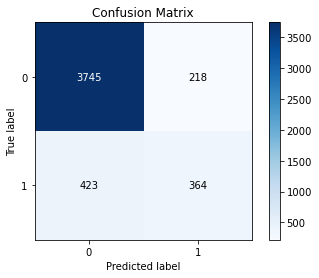

In [69]:
hackday.plot_cm(lgbm, X_test, y_test)

In [71]:
pd.read_csv('../data/submission.csv')['limite_adicional'].value_counts(normalize=True)

Negar       0.893
Conceder    0.107
Name: limite_adicional, dtype: float64

In [42]:
pd.read_csv('../data/submission.csv')['limite_adicional'].value_counts(normalize=True)

FileNotFoundError: [Errno 2] No such file or directory: '../data/submission.csv'

In [31]:
df_raw['limite_adicional'].mean()

0.15842105263157893

### Column Selection

In [34]:
forest = ExtraTreesClassifier(n_estimators=250, random_state=3, n_jobs=-1)


#data preparation
x_train_n = X_train.copy()
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=3)

Feature ranking:
                     feature  importance
0                 taxa_juros        0.17
0        dias_atraso_dt_venc        0.13
0        num_pgtos_atrasados        0.08
0        num_cartoes_credito        0.07
0       divida/saldos_atuais        0.07
0       num_contas_bancarias        0.06
0                      idade        0.06
0  divida_atual/renda_mensal        0.06
0      num_consultas_credito        0.05
0    taxa_utilizacao_credito        0.05
0              score_credito        0.05
0                renda_anual        0.05
0            num_emprestimos        0.05
0                 negativado        0.02
0           investe_exterior        0.01
0           pessoa_polit_exp        0.01


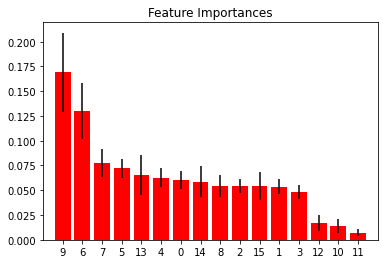

In [37]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#print the feature ranking
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j},index=[0])
    df = pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance', ascending=False))

#Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]),importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]),indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show();


In [45]:
cols_selected = df.sort_values('importance', ascending = False)['feature'][:-3].tolist()

### Teste

In [31]:
pred = pipe.predict(X_submission)

In [32]:
submission = pd.DataFrame()

In [33]:
submission['id_cliente'] = ids
submission['limite_adicional'] = pred

In [34]:
map_resposta = {0: 'Negar', 1: 'Conceder'}

In [35]:
submission['limite_adicional'] = submission['limite_adicional'].map(map_resposta)

In [36]:
submission.to_csv('../data/submissao.csv', index=False)

In [37]:
pd.read_csv('../data/submissao.csv')

,id_cliente,limite_adicional
0,2,Conceder
1,5,Negar
2,6,Negar
3,8,Negar
4,10,Negar
...,...,...
2995,12484,Negar
2996,12487,Negar
2997,12489,Negar
2998,12495,Conceder
